In [3]:

import json
import os
import numpy as np
import matplotlib.pyplot as plt

def process_json(json_file, target_length=400):
    """
    Membaca data dari file JSON dan memastikan semua nilai bertipe float atau np.nan.
    - Jika nilai None di JSON, diganti dengan np.nan.
    - Jika nilai lebih sedikit dari target_length, sisanya diisi dengan np.nan.
    - Jika lebih banyak, dipotong (slice) sesuai target_length.
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Buat dict dengan key int(episode) dan value float (atau np.nan)
        processed_data = {}
        for k, v in data.items():
            episode_index = int(k)
            if v is None:
                processed_data[episode_index] = np.nan
            else:
                # Pastikan bisa dikonversi ke float
                processed_data[episode_index] = float(v)
        
        # Urutkan berdasarkan episode, lalu ambil nilainya
        sorted_keys = sorted(processed_data.keys())
        sorted_values = [processed_data[k] for k in sorted_keys]

        # Potong/isi agar panjang data sesuai target_length
        adjusted_data = sorted_values[:target_length]
        if len(adjusted_data) < target_length:
            adjusted_data += [np.nan] * (target_length - len(adjusted_data))
        
        return adjusted_data
    else:
        print(f"[Warning] File {json_file} tidak ditemukan. Mengembalikan array np.nan.")
        return [np.nan] * target_length

def rolling_stats(data, window_size=10):
    """
    Menghitung rolling average dan rolling standard deviation untuk data.
    - Abaikan np.nan (tidak ikut dihitung).
    - Hasilnya berupa list yang sama panjang dengan data asli.
    """
    avg_list = []
    std_list = []

    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        window = data[start_idx : i + 1]
        
        # Ambil nilai valid (bukan np.nan)
        valid_vals = [val for val in window if not np.isnan(val)]
        
        if len(valid_vals) > 0:
            mean_val = np.mean(valid_vals)
            std_val  = np.std(valid_vals)
        else:
            mean_val = np.nan
            std_val  = np.nan

        avg_list.append(mean_val)
        std_list.append(std_val)

    return avg_list, std_list

def plot_metrics_with_shadow(json_files, labels,
                             title, xlabel, ylabel,
                             x_tick_interval=50, y_tick_interval=50,
                             target_length=400,
                             window_size=10,
                             y_min=-600, y_max=300
                             ):
    """
    Membuat plot dari beberapa file JSON:
    1. (Raw data TIDAK ditampilkan)
    2. Plot rolling average untuk setiap data.
    3. Tambahkan 'shadow' (fill_between) berdasarkan standard deviation.
    """
    plt.figure(figsize=(10, 8))

    # Rentang episode untuk sumbu x
    x_values = range(target_length)

    for json_file, label in zip(json_files, labels):
        # Ambil data (tidak kita plot raw-nya)
        data = process_json(json_file, target_length)
        
        # Hitung rolling average & std
        avg_list, std_list = rolling_stats(data, window_size=window_size)

        # Plot garis rolling average
        (line,) = plt.plot(x_values, avg_list, label=f"{label}", linewidth=2)

        # Siapkan batas atas dan bawah untuk area shadow
        upper_bound = []
        lower_bound = []
        for m, s in zip(avg_list, std_list):
            if not np.isnan(m) and not np.isnan(s):
                upper_bound.append(m + s)
                lower_bound.append(m - s)
            else:
                upper_bound.append(np.nan)
                lower_bound.append(np.nan)

        # Fill area di sekitar rolling average (shadow)
        plt.fill_between(
            x_values,
            lower_bound,
            upper_bound,
            color=line.get_color(),
            alpha=0.2
        )

    # Konfigurasi sumbu X
    plt.xticks(
        range(0, target_length + 1, x_tick_interval),
        fontsize=12,
        rotation=45
    )

    # Konfigurasi sumbu Y
    plt.yticks(
        np.arange(y_min, y_max + 1, y_tick_interval),
        fontsize=12
    )
    plt.ylim(y_min, y_max)

    # Judul, Label, dan Legenda
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlim(0,500)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()
# Ganti path di bawah dengan path di mana JSON Anda disimpan
#TD3_dir = 'D:/KULIAH/skripsi/CODE/skripsi/1_TD3_origin/saved_models_2_final'
#HITL_dir = 'D:/KULIAH/skripsi/CODE/skripsi/3_HITL/ruled_based_4'

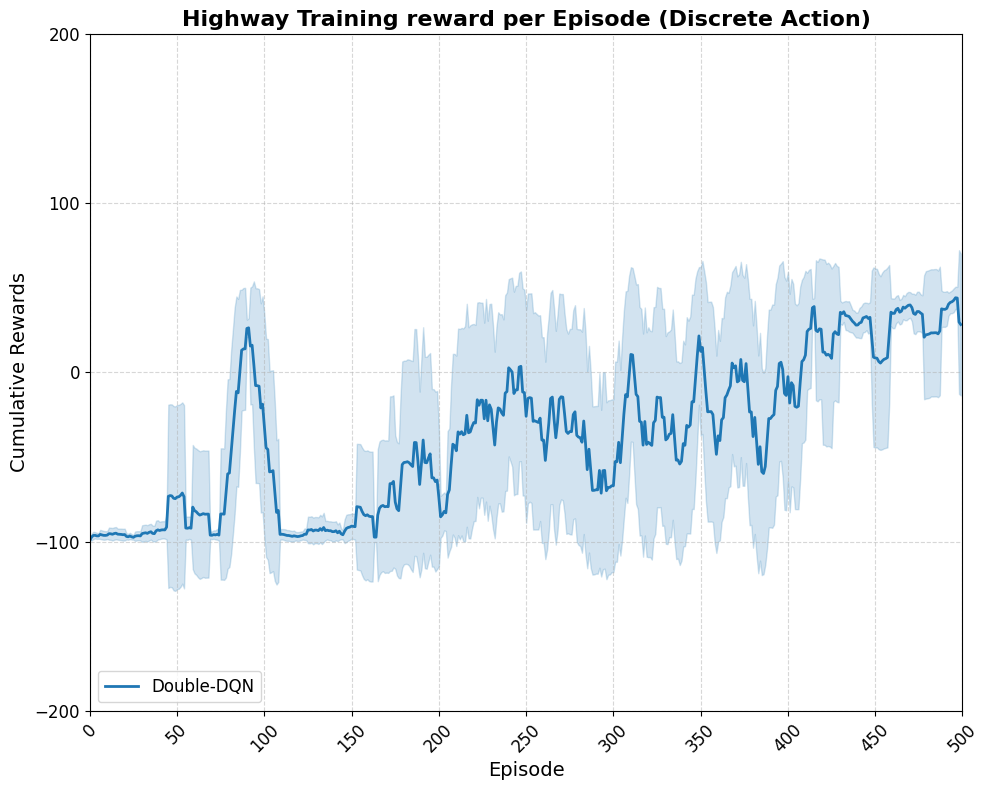

In [11]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\4_Highway'
DQN_dir = os.path.join(env_dir, '2_Double_DQN', 'model_1')


files = [
    os.path.join(DQN_dir, 'A_cumulative_rewards.json'),

]
#labels = ['Double-DQN','HITL+Double-DQN','HG1', 'HG2']
labels = ['Double-DQN']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Highway Training reward per Episode (Discrete Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=50,
    y_tick_interval=100,
    target_length=500,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-200,
    y_max=200,
)